In [ ]:
# Import necessary libraries
import sys, os, glob, time, imageio
import numpy as np, pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image

import torch
import torchvision.utils as vutils
import torchvision.transforms as transforms

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

import tensorflow as tf
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


In [ ]:
# Root directory for dataset in Google Drive
google_drive_root = r'C:\Users\DELL\Downloads\archive\chest_xray\\' # Replace with your folder structure
dataroot_train = os.path.join(google_drive_root, 'chest_xray', 'train')
dataroot_test = os.path.join(google_drive_root, 'chest_xray', 'test')
dataroot_val = os.path.join(google_drive_root, 'chest_xray', 'val')

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 40

# Learning rate for optimizers
lr = 0.00005  # WGAN typically uses a lower learning rate

# Beta1 hyperparam for Adam optimizers
beta1 = 0.0  # WGAN paper recommends beta1=0

# Weight clipping parameter
weight_clip = 0.01  # Typically small value like 0.01

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


Image has 1 channel


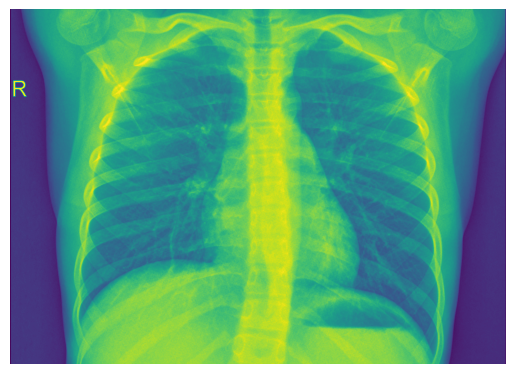

In [ ]:
def check_Image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

from PIL import Image
import numpy as np
import os

# Update filename with the path in Google Drive
filename = r'C:\Users\DELL\Downloads\archive\chest_xray\\test\\NORMAL\\IM-0003-0001.jpeg'  # Replace with your folder structure

# Check if the file exists
if not os.path.exists(filename):
    raise FileNotFoundError(f"File not found: {filename}")

# Open image using PIL
im = Image.open(filename)
im.show()

# Convert to numpy array
img = np.array(im)

# Find number of channels
if img.ndim == 2:
    channels = 1
    print("Image has 1 channel")
else:
    channels = img.shape[-1]  # Corrected from 'image' to 'img'
    print("Image has", channels, "channels")

# Display the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(filename))
plt.axis('off')
plt.show()





In [ ]:
# Define the datasets
dataset_train = dset.ImageFolder(root=dataroot_train,
                                 is_valid_file=check_Image,
                                 transform=transforms.Compose([
                                     transforms.Grayscale(num_output_channels=1),
                                     transforms.Resize(image_size),
                                     transforms.CenterCrop(image_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5), (0.5)),
                                 ]))

dataset_test = dset.ImageFolder(root=dataroot_test,
                                is_valid_file=check_Image,
                                transform=transforms.Compose([
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5), (0.5)),
                                ]))

dataset_val = dset.ImageFolder(root=dataroot_val,
                               is_valid_file=check_Image,
                               transform=transforms.Compose([
                                   transforms.Grayscale(num_output_channels=1),
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5), (0.5)),
                               ]))

# Combine datasets
l = []
l.append(dataset_train)
l.append(dataset_test)
l.append(dataset_val)
image_datasets = torch.utils.data.ConcatDataset(l)

# Create dataloader
dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Set device
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


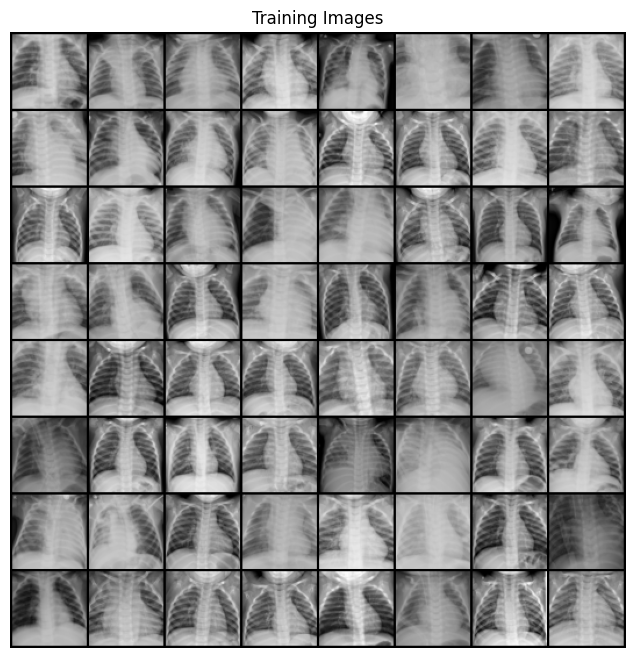

In [ ]:
# Visualize some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


In [ ]:
# Weight initialization function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
# WGAN Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.seq_model = nn.Sequential(
            # Input: Z latent vector
            nn.ConvTranspose2d(in_channels = nz,
                               out_channels = ngf * 8,
                               kernel_size = 4,
                               stride = 1,
                               padding = 0,
                               bias=False),
            nn.BatchNorm2d(num_features = ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = ngf * 8,
                               out_channels = ngf * 4,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(num_features = ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = ngf * 4,
                               out_channels = ngf * 2,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(num_features = ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = ngf * 2,
                               out_channels = ngf,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(num_features = ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels = ngf,
                               out_channels = nc,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1,
                               bias=False),
            nn.Tanh()
        )

    def forward(self, inputs):
        return self.seq_model(inputs)


In [ ]:
# Create the generator
netG = Generator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)

# Print the Generator model
print(netG)


Generator(
  (seq_model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

In [ ]:
# WGAN Discriminator (Critic)
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input: (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf) x 32 x 32

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*2) x 16 x 16

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*4) x 8 x 8

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
            # Output: 1 value without activation
        )

    def forward(self, input):
        return self.main(input).view(-1)


In [ ]:
# Create the Discriminator (Critic)
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
netD.apply(weights_init)

# Print the Discriminator model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [ ]:
# Initialize the optimizer
# WGAN uses RMSProp or Adam with specific hyperparameters
# Here, we'll use Adam with beta1=0.0 and beta2=0.9 as per WGAN recommendations
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.9))


In [ ]:
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np
from torch_fidelity import calculate_metrics

# Function to compute PSNR
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

# Function to compute SSIM
def calculate_ssim(img1, img2):
    img1 = img1.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to Numpy (BCHW to BHWC)
    img2 = img2.cpu().numpy().transpose(0, 2, 3, 1)

    ssim_values = []
    for i in range(img1.shape[0]):
        height, width, _ = img1[i].shape
        min_dim = min(height, width)
        win_size = min(7, min_dim) if min_dim >= 3 else 3  # Ensure a minimum of 3x3 window

        ssim_val = ssim(
            img1[i],
            img2[i],
            win_size=win_size,
            data_range=1.0,   # Assuming pixel values are normalized to [0, 1]
            channel_axis=-1   # Explicitly set the axis for color channels
        )
        ssim_values.append(ssim_val)

    return np.mean(ssim_values)

# Function to compute FID
def calculate_fid_score(real_images, fake_images):
    """
    Calculate the FID score between real and fake images using torch_fidelity.

    Parameters:
        real_images (torch.Tensor): Real images (B, C, H, W) normalized to [0, 1].
        fake_images (torch.Tensor): Fake images (B, C, H, W) normalized to [0, 1].

    Returns:
        float: The FID score.
    """
    real_images = (real_images * 255).byte()  # Convert to [0, 255] range
    fake_images = (fake_images * 255).byte()

    # Save real and fake images as temporary folders
    import tempfile
    from torchvision.utils import save_image

    with tempfile.TemporaryDirectory() as real_dir, tempfile.TemporaryDirectory() as fake_dir:
        # Save images to their respective folders
        for i, img in enumerate(real_images):
            save_image(img.float() / 255.0, f"{real_dir}/real_{i}.png")
        for i, img in enumerate(fake_images):
            save_image(img.float() / 255.0, f"{fake_dir}/fake_{i}.png")

        # Calculate FID using the saved folders
        metrics = calculate_metrics(
            input1=real_dir,
            input2=fake_dir,
            cuda=torch.cuda.is_available(),
            fid=True  # Enable FID computation
        )
    return metrics["frechet_inception_distance"]


In [ ]:
# Initialize lists to track metrics
fid_scores = []
psnr_scores = []
ssim_scores = []

img_list = []
G_losses = []
D_losses = []
iters = 0


print("Starting Training Loop...")
# Define number of critic iterations per generator iteration
n_critic = 5  # WGAN recommends more critic updates per generator update

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update Discriminator (Critic) n_critic times
        ###########################
        for _ in range(n_critic):
            netD.zero_grad()
            real_data = data[0].to(device)
            b_size = real_data.size(0)

            # Forward pass real batch through D
            D_real = netD(real_data)
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            # Forward pass fake batch through D
            D_fake = netD(fake.detach())
            # Compute WGAN loss
            loss_D = -(torch.mean(D_real) - torch.mean(D_fake))
            # Backward pass
            loss_D.backward()
            # Update D
            optimizerD.step()

            # Weight clipping
            for p in netD.parameters():
                p.data.clamp_(-weight_clip, weight_clip)

        ############################
        # (2) Update Generator
        ###########################
        netG.zero_grad()
        # Generate fake image batch with G
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        # Compute G's loss based on D's output
        D_fake = netD(fake)
        loss_G = -torch.mean(D_fake)
        # Backward pass
        loss_G.backward()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                real_images = data[0].cpu()

            min_batch_size = min(real_images.size(0), fake.size(0))
            real_images = real_images[:min_batch_size]
            fake = fake[:min_batch_size]
            # Calculate PSNR
            psnr_score = calculate_psnr(real_images, fake)
            psnr_scores.append(psnr_score)

            # Calculate SSIM
            ssim_score = calculate_ssim(real_images, fake)
            ssim_scores.append(ssim_score)

            # Calculate FID
            fid_score = calculate_fid_score(real_images, fake)
            fid_scores.append(fid_score)

            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/40][0/46]	Loss_D: -0.0033	Loss_G: 0.0028


Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to C:\Users\DELL/.cache\torch\hub\checkpoints\weights-inception-2015-12-05-6726825d.pth
100.0%
Extracting statistics from input 1
Looking for samples non-recursivelty in "C:\Users\DELL\AppData\Local\Temp\tmpjrzipo7j" with extensions png,jpg,jpeg
Found 64 samples
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch_fidelity\datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, widt

[1/40][0/46]	Loss_D: -1.0668	Loss_G: 0.5207
[2/40][0/46]	Loss_D: -1.0537	Loss_G: 0.4986
[3/40][0/46]	Loss_D: -0.9931	Loss_G: 0.5381
[4/40][0/46]	Loss_D: -1.1128	Loss_G: 0.5978
[5/40][0/46]	Loss_D: -1.1466	Loss_G: 0.6357
[6/40][0/46]	Loss_D: -1.1767	Loss_G: 0.5968
[7/40][0/46]	Loss_D: -1.2291	Loss_G: 0.6048
[8/40][0/46]	Loss_D: -1.2409	Loss_G: 0.6093
[9/40][0/46]	Loss_D: -1.2823	Loss_G: 0.6451
[10/40][0/46]	Loss_D: -1.1501	Loss_G: 0.5082


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "C:\Users\DELL\AppData\Local\Temp\tmpjc2obheq" with extensions png,jpg,jpeg
Found 64 samples
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "C:\Users\DELL\AppData\Local\Temp\tmpevza1dko" with extensions png,jpg,jpeg
Found 64 samples
Processing samples                                                      
Frechet Inception Distance: 336.37996612433363


[11/40][0/46]	Loss_D: -1.0219	Loss_G: 0.4248
[12/40][0/46]	Loss_D: -0.9918	Loss_G: 0.4776
[13/40][0/46]	Loss_D: -0.9868	Loss_G: 0.5836
[14/40][0/46]	Loss_D: -0.9446	Loss_G: 0.4309
[15/40][0/46]	Loss_D: -0.9392	Loss_G: 0.3767
[16/40][0/46]	Loss_D: -0.9871	Loss_G: 0.4451
[17/40][0/46]	Loss_D: -0.9502	Loss_G: 0.4102
[18/40][0/46]	Loss_D: -0.9602	Loss_G: 0.4048
[19/40][0/46]	Loss_D: -0.9773	Loss_G: 0.5297
[20/40][0/46]	Loss_D: -0.9286	Loss_G: 0.4698
[21/40][0/46]	Loss_D: -0.9771	Loss_G: 0.5723


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "C:\Users\DELL\AppData\Local\Temp\tmpn3h4id5a" with extensions png,jpg,jpeg
Found 64 samples
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "C:\Users\DELL\AppData\Local\Temp\tmphydg1gqt" with extensions png,jpg,jpeg
Found 64 samples
Processing samples                                                      
Frechet Inception Distance: 252.5213889868575


[22/40][0/46]	Loss_D: -0.7900	Loss_G: 0.5906
[23/40][0/46]	Loss_D: -0.9771	Loss_G: 0.5434
[24/40][0/46]	Loss_D: -0.9282	Loss_G: 0.3204
[25/40][0/46]	Loss_D: -0.9531	Loss_G: 0.5416
[26/40][0/46]	Loss_D: -0.8958	Loss_G: 0.3585
[27/40][0/46]	Loss_D: -1.0033	Loss_G: 0.5748
[28/40][0/46]	Loss_D: -0.8754	Loss_G: 0.2717
[29/40][0/46]	Loss_D: -0.9786	Loss_G: 0.5411
[30/40][0/46]	Loss_D: -0.9628	Loss_G: 0.5092
[31/40][0/46]	Loss_D: -0.8829	Loss_G: 0.3903
[32/40][0/46]	Loss_D: -0.8210	Loss_G: 0.2642


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "C:\Users\DELL\AppData\Local\Temp\tmpg2thsv18" with extensions png,jpg,jpeg
Found 64 samples
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "C:\Users\DELL\AppData\Local\Temp\tmphzqmxdq9" with extensions png,jpg,jpeg
Found 64 samples
Processing samples                                                      
Frechet Inception Distance: 218.14015589535506


[33/40][0/46]	Loss_D: -0.9447	Loss_G: 0.5429
[34/40][0/46]	Loss_D: -0.9504	Loss_G: 0.5658
[35/40][0/46]	Loss_D: -0.8606	Loss_G: 0.2881
[36/40][0/46]	Loss_D: -0.9100	Loss_G: 0.3564
[37/40][0/46]	Loss_D: -0.8242	Loss_G: 0.3977
[38/40][0/46]	Loss_D: -0.9782	Loss_G: 0.4893
[39/40][0/46]	Loss_D: -0.8990	Loss_G: 0.3193


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "C:\Users\DELL\AppData\Local\Temp\tmp0vno3byb" with extensions png,jpg,jpeg
Found 64 samples
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "C:\Users\DELL\AppData\Local\Temp\tmp0de77xve" with extensions png,jpg,jpeg
Found 64 samples
Processing samples                                                      
Frechet Inception Distance: 208.8198716410746


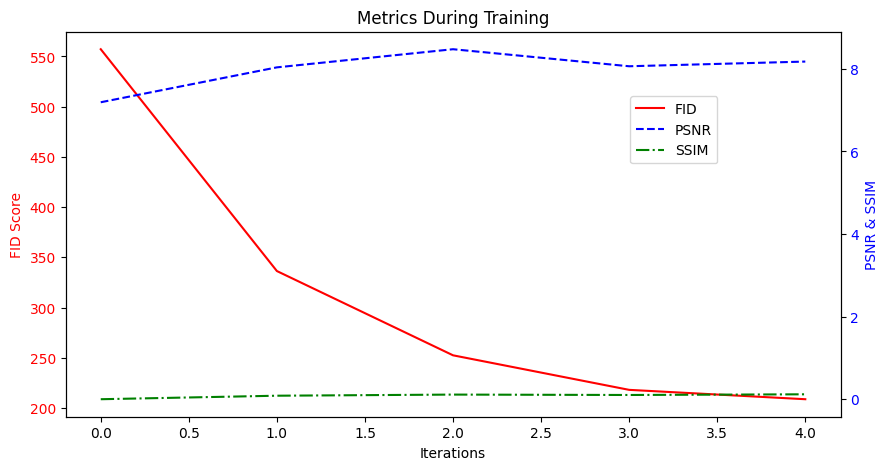

In [ ]:
import matplotlib.pyplot as plt

# Plot FID on the left y-axis
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_title("Metrics During Training")
ax1.plot(fid_scores, label="FID", color="red")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("FID Score", color="red")
ax1.tick_params(axis="y", labelcolor="red")

# Create a twin y-axis for PSNR and SSIM
ax2 = ax1.twinx()
ax2.plot(psnr_scores, label="PSNR", color="blue", linestyle="--")
ax2.plot(ssim_scores, label="SSIM", color="green", linestyle="-.")
ax2.set_ylabel("PSNR & SSIM", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Add legends for both y-axes
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85), bbox_transform=ax1.transAxes)

plt.show()


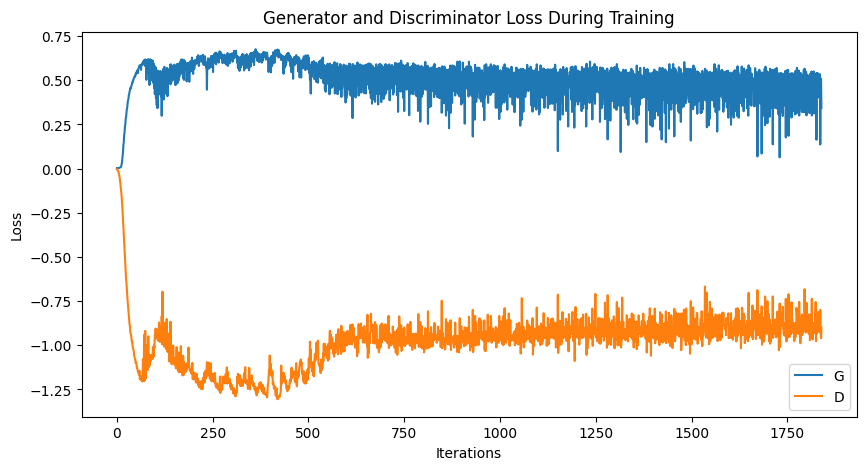

In [ ]:
# Plot Generator and Discriminator Loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


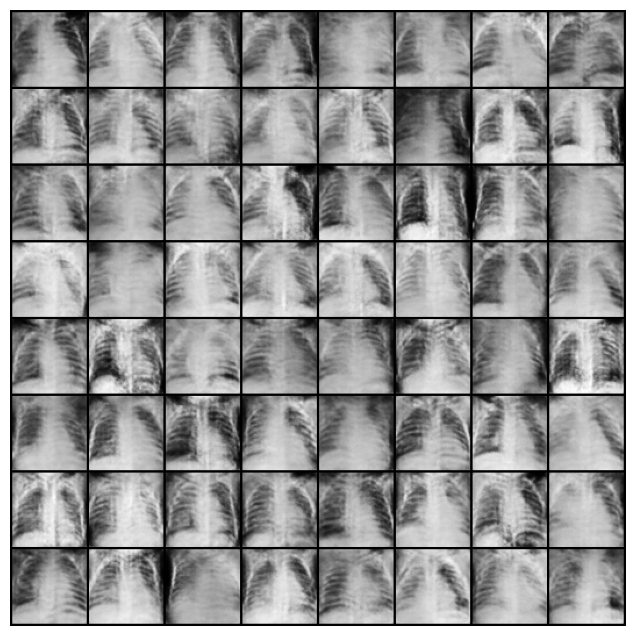

In [ ]:
# Generate and display the animation of generated images
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())
